In [1]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-4iew_c3g
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-4iew_c3g
  Created wheel for dm-haiku: filename=dm_haiku-0.0.2-cp36-none-any.whl size=289551 sha256=bdaaca0232060c6903025795c49eddd0c70d0bfb7b2d61c7f32649b0aa5edeff
  Stored in directory: /tmp/pip-ephem-wheel-cache-2diuz5o2/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku


In [2]:
import functools
from typing import Any, NamedTuple

import haiku as hk
import jax
from jax.experimental import optix
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Model

## Utils

In [4]:
def tree_shape(xs):
  return jax.tree_map(lambda x: x.shape, xs)


def sparse_softmax_cross_entropy(logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1)

## Generator and Discriminator

In [5]:
class Generator(hk.Module):
  """Generator network."""
  
  def __init__(self, output_channels=(32, 1), name=None):
    super().__init__(name=name)
    self.output_channels = output_channels

  def __call__(self, x):
    """Maps noise latents to images."""
    x = hk.Linear(7 * 7 * 64)(x)
    x = jnp.reshape(x, x.shape[:1] + (7, 7, 64)) 
    for output_channels in self.output_channels:
      x = jax.nn.relu(x)
      x = hk.Conv2DTranspose(output_channels=output_channels,
                             kernel_shape=[5, 5],
                             stride=2,
                             padding="SAME")(x)
    # We use a tanh to ensure that the generated samples are in the same
    # range as the data.
    return jnp.tanh(x)

In [6]:
class Discriminator(hk.Module):
  """Discriminator network."""

  def __init__(self,
               output_channels=(8, 16, 32, 64, 128),
               strides=(2, 1, 2, 1, 2),
               name=None):   
    super().__init__(name=name)
    self.output_channels = output_channels
    self.strides = strides

  def __call__(self, x):
    """Classifies images as real or fake."""
    for output_channels, stride in zip(self.output_channels, self.strides):
      x = hk.Conv2D(output_channels=output_channels,
                    kernel_shape=[5, 5],
                    stride=stride,
                    padding="SAME")(x)
      x = jax.nn.leaky_relu(x, negative_slope=0.2)
    x = hk.Flatten()(x)    
    # We have two classes: 0 = input is fake, 1 = input is real.
    logits = hk.Linear(2)(x)
    return logits

## The GAN

In [7]:
class GANTuple(NamedTuple):
  gen: Any
  disc: Any


class GANState(NamedTuple):
  params: GANTuple
  opt_state: GANTuple


class GAN:
  """A basic GAN."""

  def __init__(self, num_latents):
    self.num_latents = num_latents
  
    # Define the Haiku network transforms.
    # We don't use BatchNorm so we don't use `with_state`.
    #without_apply_rng removes the rng argument from the apply function.
    self.gen_transform = hk.without_apply_rng(
        hk.transform(lambda *args: Generator()(*args))) #lambda creates object and applies it
    self.disc_transform = hk.without_apply_rng(
        hk.transform(lambda *args: Discriminator()(*args))) #lambda creates object and applies it
    
    # Build the optimizers.
    self.optimizers = GANTuple(gen=optix.adam(1e-4, b1=0.5, b2=0.9),
                               disc=optix.adam(1e-4, b1=0.5, b2=0.9))

  @functools.partial(jax.jit, static_argnums=0)
  def initial_state(self, rng, batch):
    """Returns the initial parameters and optimize states."""
    # Generate dummy latents for the generator.
    dummy_latents = jnp.zeros((batch.shape[0], self.num_latents))

    # Get initial network parameters.
    rng_gen, rng_disc = jax.random.split(rng)
    params = GANTuple(gen=self.gen_transform.init(rng_gen, dummy_latents),
                      disc=self.disc_transform.init(rng_disc, batch))
    print("Generator: \n\n{}\n".format(tree_shape(params.gen)))
    print("Discriminator: \n\n{}\n".format(tree_shape(params.disc)))
    
    # Initialize the optimizers.
    opt_state = GANTuple(gen=self.optimizers.gen.init(params.gen),
                         disc=self.optimizers.disc.init(params.disc))
    
    return GANState(params=params, opt_state=opt_state)

  def sample(self, rng, gen_params, num_samples):
    """Generates images from noise latents."""
    latents = jax.random.normal(rng, shape=(num_samples, self.num_latents))
    return self.gen_transform.apply(gen_params, latents)

  def gen_loss(self, gen_params, rng, disc_params, batch):
    """Generator loss."""
    # Sample from the generator.
    fake_batch = self.sample(rng, gen_params, num_samples=batch.shape[0])

    # Evaluate using the discriminator. Recall class 1 is real.
    fake_logits = self.disc_transform.apply(disc_params, fake_batch)
    fake_probs = jax.nn.softmax(fake_logits)[:, 1]
    loss = -jnp.log(fake_probs)
    
    return jnp.mean(loss)

  def disc_loss(self, disc_params, rng, gen_params, batch):
    """Discriminator loss."""
    # Sample from the generator.
    fake_batch = self.sample(rng, gen_params, num_samples=batch.shape[0])

    # For efficiency we process both the real and fake data in one pass.
    real_and_fake_batch = jnp.concatenate([batch, fake_batch], axis=0)
    real_and_fake_logits = self.disc_transform.apply(disc_params, 
                                                     real_and_fake_batch)
    real_logits, fake_logits = jnp.split(real_and_fake_logits, 2, axis=0)

    # Class 1 is real.
    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = sparse_softmax_cross_entropy(real_logits, real_labels)

    # Class 0 is fake.
    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = sparse_softmax_cross_entropy(fake_logits, fake_labels)

    return jnp.mean(real_loss + fake_loss)

  @functools.partial(jax.jit, static_argnums=0)
  def update(self, rng, gan_state, batch):
    """Performs a parameter update."""
    rng, rng_gen, rng_disc = jax.random.split(rng, 3)
    
    # Update the discriminator.
    disc_loss, disc_grads = jax.value_and_grad(self.disc_loss)(
        gan_state.params.disc,
        rng_disc, 
        gan_state.params.gen,
        batch)
    disc_update, disc_opt_state = self.optimizers.disc.update(
        disc_grads, gan_state.opt_state.disc)
    disc_params = optix.apply_updates(gan_state.params.disc, disc_update)

    # Update the generator.
    gen_loss, gen_grads = jax.value_and_grad(self.gen_loss)(
        gan_state.params.gen,
        rng_gen, 
        gan_state.params.disc,
        batch)
    gen_update, gen_opt_state = self.optimizers.gen.update(
        gen_grads, gan_state.opt_state.gen)
    gen_params = optix.apply_updates(gan_state.params.gen, gen_update)
    
    params = GANTuple(gen=gen_params, disc=disc_params)
    opt_state = GANTuple(gen=gen_opt_state, disc=disc_opt_state)
    gan_state = GANState(params=params, opt_state=opt_state)
    log = {
        "gen_loss": gen_loss,
        "disc_loss": disc_loss,
    }

    return rng, gan_state, log

# Dataset

In [8]:
mnist = tfds.load("mnist")
def make_dataset(batch_size, seed=1):
  def _preprocess(sample):
    image = tf.image.convert_image_dtype(sample["image"], tf.float32)
    return 2.0 * image - 1.0

  ds = mnist["train"]
  ds = ds.map(map_func=_preprocess, 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()
  ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
  return tfds.as_numpy(ds)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [9]:
@title {vertical-output: true}

num_steps = 20001
log_every = num_steps // 100

# Let's see what hardware we're working with. The training takes a few
# minutes on a GPU, a bit longer on CPU.
print(f"Number of devices: {jax.device_count()}")
print("Device:", jax.devices()[0].device_kind)
print("")

# Make the dataset.
dataset = make_dataset(batch_size=64)

# The model.
gan = GAN(num_latents=20)

# Top-level RNG.
rng = jax.random.PRNGKey(1729)

# Initialize the network and optimizer.
rng, rng1 = jax.random.split(rng)
gan_state = gan.initial_state(rng1, next(dataset))

steps = []
gen_losses = []
disc_losses = []

for step in range(num_steps):
  rng, gan_state, log = gan.update(rng, gan_state, next(dataset))

  # Log the losses.
  if step % log_every == 0:   
    # It's important to call `device_get` here so we don't take up device
    # memory by saving the losses.
    log = jax.device_get(log)
    gen_loss = log["gen_loss"]
    disc_loss = log["disc_loss"]
    print(f"Step {step}: "
          f"gen_loss = {gen_loss:.3f}, disc_loss = {disc_loss:.3f}")
    steps.append(step)
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

Number of devices: 1
Device: Tesla T4

Generator: 

frozendict({
  'generator/conv2_d_transpose': frozendict({'b': (32,), 'w': (5, 5, 32, 64)}),
  'generator/conv2_d_transpose_1': frozendict({'b': (1,), 'w': (5, 5, 1, 32)}),
  'generator/linear': frozendict({'b': (3136,), 'w': (20, 3136)}),
})

Discriminator: 

frozendict({
  'discriminator/conv2_d': frozendict({'b': (8,), 'w': (5, 5, 1, 8)}),
  'discriminator/conv2_d_1': frozendict({'b': (16,), 'w': (5, 5, 8, 16)}),
  'discriminator/conv2_d_2': frozendict({'b': (32,), 'w': (5, 5, 16, 32)}),
  'discriminator/conv2_d_3': frozendict({'b': (64,), 'w': (5, 5, 32, 64)}),
  'discriminator/conv2_d_4': frozendict({'b': (128,), 'w': (5, 5, 64, 128)}),
  'discriminator/linear': frozendict({'b': (2,), 'w': (2048, 2)}),
})

Step 0: gen_loss = 0.696, disc_loss = 1.421
Step 200: gen_loss = 3.642, disc_loss = 0.048
Step 400: gen_loss = 4.194, disc_loss = 0.061
Step 600: gen_loss = 4.832, disc_loss = 0.058
Step 800: gen_loss = 4.633, disc_loss = 0.391

# Visualizations

## Visualize the losses

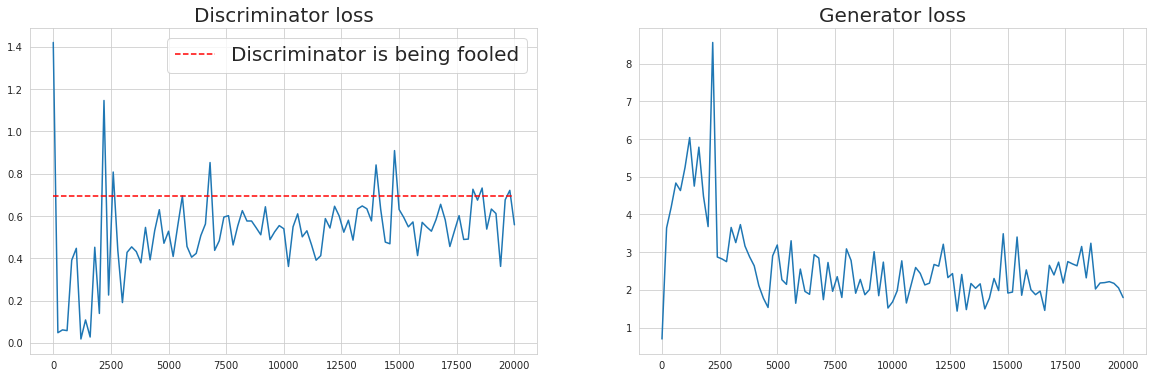

In [10]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the discriminator loss.
axes[0].plot(steps, disc_losses, "-")
axes[0].plot(steps, np.log(2) * np.ones_like(steps), "r--", 
             label="Discriminator is being fooled")
axes[0].legend(fontsize=20)
axes[0].set_title("Discriminator loss", fontsize=20)

# Plot the generator loss.
axes[1].plot(steps, gen_losses, '-')
axes[1].set_title("Generator loss", fontsize=20);

## VIsualize the samples

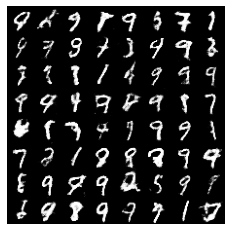

In [11]:

def make_grid(samples, num_cols=8, rescale=True): 
  batch_size, height, width = samples.shape
  assert batch_size % num_cols == 0
  num_rows = batch_size // num_cols
  # We want samples.shape == (height * num_rows, width * num_cols).
  samples = samples.reshape(num_rows, num_cols, height, width)
  samples = samples.swapaxes(1, 2)
  samples = samples.reshape(height * num_rows, width * num_cols)
  return samples


# Generate samples from the trained generator.
rng = jax.random.PRNGKey(12)
samples = gan.sample(rng, gan_state.params.gen, num_samples=64)
samples = jax.device_get(samples)
samples = samples.squeeze(axis=-1)
# Our model outputs values in [-1, 1] so scale it back to [0, 1].
samples = (samples + 1.0) / 2.0

plt.gray()
plt.axis("off")
samples_grid = make_grid(samples)
plt.imshow(samples_grid);